In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

In [12]:
model_name = "DeepChem/ChemBERTa-77M-MTR"
tokenizer = AutoTokenizer.from_pretrained(model_name)
chemberta_model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
chemberta_model.to(device)
chemberta_model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(600, 384, padding_idx=1)
    (position_embeddings): Embedding(515, 384, padding_idx=1)
    (token_type_embeddings): Embedding(1, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.144, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-2): 3 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.109, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dr

In [13]:
def featurize_smiles(smiles_list):
    features = []
    with torch.no_grad():
        for smiles in smiles_list:
            encoded = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True).to(device)
            output = chemberta_model(**encoded)
            features.append(output.pooler_output.squeeze(0))

    features_tensor = torch.stack(features)
    return features_tensor.to(dtype=torch.float32)

In [14]:
df = pd.read_csv("/kaggle/input/qm9-smiles-props/qm9_smiles_properties.csv")  
smiles = df["SMILES"].values
target = df["G"].values 

features = featurize_smiles(smiles)

In [15]:
def prepare_data(features, target, train_size=0.75):
    X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=(1 - train_size), random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [16]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim):
        super(PredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [17]:
def train_model(features, target, epochs, train_size, batch_size=32, lr=0.001):
    print(f"\nTraining with {int(train_size * 100)}% of the data:")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(features, target, train_size)
    
    train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
    val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
    test_tensor = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))
    
    train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)
    
    input_dim = features.shape[1]
    model = PredictionModel(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    consecutive_increase_counter = 0
    max_allowed_increases = 4
    prev_val_loss = float('inf')
    
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        if avg_val_loss > prev_val_loss:
            consecutive_increase_counter += 1
        else:
            consecutive_increase_counter = 0 
        
        if consecutive_increase_counter >= max_allowed_increases:
            print("Early stopping triggered!")
            break
        
        prev_val_loss = avg_val_loss

    plt.plot(train_losses[1:], label='Train Loss')
    plt.plot(val_losses[1:], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model, test_loader, device

In [18]:
def evaluate_model(model, test_loader, device):
    model.eval()
    actual_values, predicted_values = [], []

    start_time = time.time()
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze()
            actual_values.extend(batch_y.cpu().numpy())
            predicted_values.extend(outputs.cpu().numpy())
    end_time = time.time()
    
    actual_values, predicted_values = np.array(actual_values), np.array(predicted_values)
    
    mse = mean_squared_error(actual_values, predicted_values)
    mae = mean_absolute_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)
    inference_time = (end_time - start_time) / len(test_loader)

    print(f"Inference Time per 1000 samples: {inference_time*1000:.4f} seconds")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-Squared (R²): {r2:.4f}")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.6, label="Predictions")
    plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color="red", linestyle="--", label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    plt.legend()
    plt.grid()
    plt.show()


Training with 75% of the data:


/tmp/ipykernel_31/3804434592.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
/tmp/ipykernel_31/3804434592.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
/tmp/ipykernel_31/3804434592.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = TensorDataset(t

Epoch [1/100], Train Loss: 5751.2638, Validation Loss: 270.1701
Epoch [2/100], Train Loss: 217.4470, Validation Loss: 174.0171
Epoch [3/100], Train Loss: 158.6105, Validation Loss: 142.3173
Epoch [4/100], Train Loss: 129.6282, Validation Loss: 115.9309
Epoch [5/100], Train Loss: 111.6928, Validation Loss: 108.0852
Epoch [6/100], Train Loss: 99.6747, Validation Loss: 93.3862
Epoch [7/100], Train Loss: 91.0559, Validation Loss: 84.8455
Epoch [8/100], Train Loss: 84.3881, Validation Loss: 78.3737
Epoch [9/100], Train Loss: 79.1146, Validation Loss: 77.7039
Epoch [10/100], Train Loss: 74.8570, Validation Loss: 71.2635
Epoch [11/100], Train Loss: 70.3924, Validation Loss: 67.7260
Epoch [12/100], Train Loss: 66.9475, Validation Loss: 64.0210
Epoch [13/100], Train Loss: 64.5001, Validation Loss: 61.8394
Epoch [14/100], Train Loss: 61.5072, Validation Loss: 56.5458
Epoch [15/100], Train Loss: 59.7978, Validation Loss: 60.5789
Epoch [16/100], Train Loss: 58.2648, Validation Loss: 54.9970
Epoch 

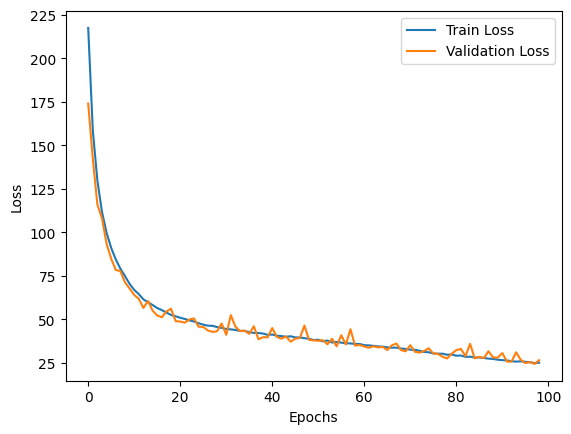

Inference Time per 1000 samples: 0.6202 seconds
Mean Squared Error (MSE): 25.5071
Mean Absolute Error (MAE): 3.5190
R-Squared (R²): 0.9840


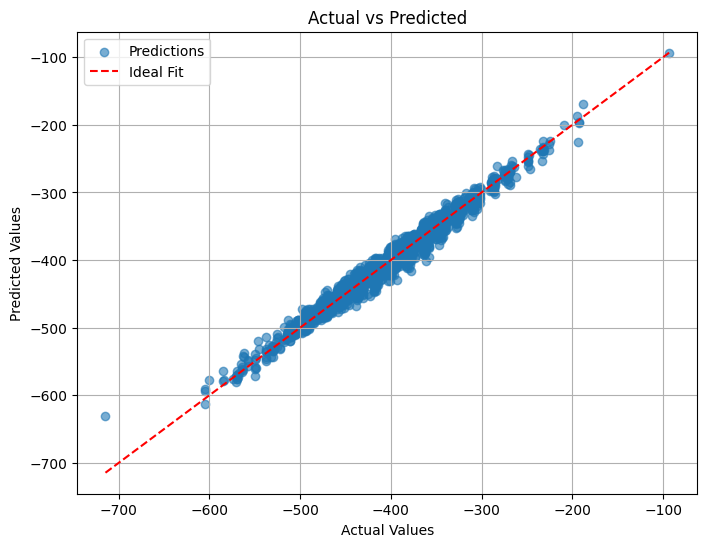

In [20]:
trained_model, test_loader, device = train_model(features, target, epochs=100, train_size=0.75)
evaluate_model(trained_model, test_loader, device)

# **Property Conditioned VAE**

In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [22]:
df = pd.read_csv('/kaggle/input/qm9-smiles-props/qm9_smiles_properties.csv')
df = df[['SMILES', 'G']].dropna()

In [35]:
MAX_LEN = max(len(s) + 2 for s in df['SMILES']) 
BATCH_SIZE = 64
LATENT_DIM = 64
PROPERTY_DIM = 1
HIDDEN_DIM = 256
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
tokens = set()
for s in df['SMILES']:
    tokens.update(list(s))
tokens = sorted(tokens)
tokens = ['<pad>', '<bos>', '<eos>', '<unk>'] + tokens
tok2idx = {ch: i for i, ch in enumerate(tokens)}
idx2tok = {i: ch for ch, i in tok2idx.items()}

def tokenize(smiles):
    tokens = ['<bos>'] + list(smiles) + ['<eos>']
    ids = [tok2idx.get(t, tok2idx['<unk>']) for t in tokens]
    return ids[:MAX_LEN] + [tok2idx['<pad>']] * (MAX_LEN - len(ids))

In [37]:
class SmilesDataset(Dataset):
    def __init__(self, smiles, properties):
        self.smiles = smiles
        self.props = properties

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        x = torch.tensor(tokenize(self.smiles[idx]), dtype=torch.long)
        y = torch.tensor(self.props[idx], dtype=torch.float32)
        return x, y

In [38]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(tok2idx), HIDDEN_DIM)
        self.rnn = nn.GRU(HIDDEN_DIM, HIDDEN_DIM, batch_first=True)
        self.fc_mu = nn.Linear(HIDDEN_DIM, LATENT_DIM)
        self.fc_logvar = nn.Linear(HIDDEN_DIM, LATENT_DIM)

    def forward(self, x):
        x = self.embed(x)
        _, h = self.rnn(x)
        h = h.squeeze(0)
        return self.fc_mu(h), self.fc_logvar(h)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(tok2idx), HIDDEN_DIM)
        self.rnn = nn.GRU(HIDDEN_DIM + LATENT_DIM + PROPERTY_DIM, HIDDEN_DIM, batch_first=True)
        self.fc_out = nn.Linear(HIDDEN_DIM, len(tok2idx))

    def forward(self, x, z, prop):
        x = self.embed(x)
        seq_len = x.size(1)
        z = z.unsqueeze(1).expand(-1, seq_len, -1)
        prop = prop.unsqueeze(1).expand(-1, seq_len, -1)
        x = torch.cat([x, z, prop], dim=-1)
        out, _ = self.rnn(x)
        return self.fc_out(out)


class PropertyVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x, prop):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        logits = self.decoder(x, z, prop.unsqueeze(-1))
        return logits, mu, logvar

## 75% Training Data

In [130]:
train_smi, test_smi, train_g, test_g = train_test_split(df['SMILES'], df['G'], test_size=0.25, random_state=42)
train_ds = SmilesDataset(train_smi.tolist(), train_g.tolist())
test_ds = SmilesDataset(test_smi.tolist(), test_g.tolist())
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

model = PropertyVAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=tok2idx['<pad>'])

In [131]:
EPOCHS = 100

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = epoch_recon = epoch_kl = 0
    for x, prop in train_dl:
        x, prop = x.to(DEVICE), prop.to(DEVICE)
        optimizer.zero_grad()
        logits, mu, logvar = model(x[:, :-1], prop)  # logits: [B, MAX_LEN, V]
        target = x[:, 1:]
        logits = logits[:, :target.size(1), :]  # ensure same length
        recon_loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()
    train_losses.append(epoch_loss / len(train_dl))

    model.eval()
    with torch.no_grad():
        val_loss = val_recon = val_kl = 0
        for x, prop in test_dl:
            x, prop = x.to(DEVICE), prop.to(DEVICE)
            logits, mu, logvar = model(x[:, :-1], prop)
            target = x[:, 1:]
            logits = logits[:, :target.size(1), :]
            recon_loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
            loss = recon_loss + kl_loss
            val_loss += loss.item()
        test_losses.append(val_loss / len(test_dl))

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch [1/100], Train Loss: 1.1181, Test Loss: 0.9291
Epoch [2/100], Train Loss: 0.8930, Test Loss: 0.8631
Epoch [3/100], Train Loss: 0.8481, Test Loss: 0.8427
Epoch [4/100], Train Loss: 0.8247, Test Loss: 0.8182
Epoch [5/100], Train Loss: 0.8067, Test Loss: 0.8037
Epoch [6/100], Train Loss: 0.7977, Test Loss: 0.7891
Epoch [7/100], Train Loss: 0.7832, Test Loss: 0.7795
Epoch [8/100], Train Loss: 0.7770, Test Loss: 0.7821
Epoch [9/100], Train Loss: 0.7701, Test Loss: 0.7709
Epoch [10/100], Train Loss: 0.7668, Test Loss: 0.7728
Epoch [11/100], Train Loss: 0.7650, Test Loss: 0.7971
Epoch [12/100], Train Loss: 0.7600, Test Loss: 0.7568
Epoch [13/100], Train Loss: 0.7566, Test Loss: 0.7538
Epoch [14/100], Train Loss: 0.7532, Test Loss: 0.7591
Epoch [15/100], Train Loss: 0.7513, Test Loss: 0.7617
Epoch [16/100], Train Loss: 0.7500, Test Loss: 0.7500
Epoch [17/100], Train Loss: 0.7466, Test Loss: 0.7588
Epoch [18/100], Train Loss: 0.7447, Test Loss: 0.7501
Epoch [19/100], Train Loss: 0.7425, T

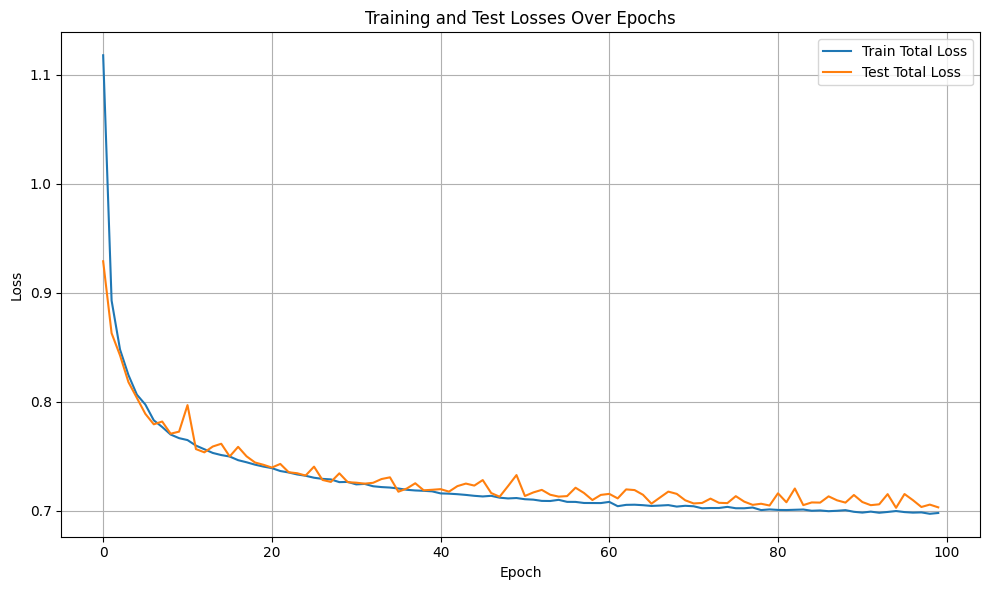

In [132]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Total Loss')
plt.plot(test_losses, label='Test Total Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [133]:
def sample(model, prop_value, max_len=MAX_LEN, temperature=1.0):
    model.eval()
    with torch.no_grad():
        z = torch.randn(1, LATENT_DIM).to(DEVICE)
        prop = torch.tensor([[prop_value]], dtype=torch.float32).to(DEVICE)
        input = torch.tensor([[tok2idx['<bos>']]], dtype=torch.long).to(DEVICE)
        generated = []
        for _ in range(max_len):
            logits = model.decoder(input, z, prop)
            logits = logits[:, -1, :] / temperature  # Apply temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).squeeze(1)
            if next_token.item() == tok2idx['<eos>']:
                break
            generated.append(next_token.item())
            input = torch.cat([input, next_token.unsqueeze(1)], dim=1)
    return ''.join([idx2tok[i] for i in generated])

In [134]:
from rdkit import Chem, RDLogger
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

RDLogger.DisableLog('rdApp.*')  

results = []  

def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

def predict_g(smiles_string, chemberta_model, tokenizer, regressor_model, device):
    with torch.no_grad():
        encoded = tokenizer(smiles_string, return_tensors="pt", padding=True, truncation=True).to(device)
        output = chemberta_model(**encoded)
        feature = output.pooler_output.squeeze(0).unsqueeze(0).to(dtype=torch.float32)
    regressor_model.eval()
    with torch.no_grad():
        prediction = regressor_model(feature.to(device)).item()
    return prediction

In [135]:
for g in test_g.tolist():
    smiles = sample(model, g, temperature = 1.0)
    if is_valid_smiles(smiles):
        try:
            pred_g = predict_g(smiles, chemberta_model, tokenizer, trained_model, device=DEVICE)
            results.append({
                "True_G": g,
                "Predicted_G": pred_g,
                "Predicted_SMILES": smiles
            })
        except Exception as e:
            print(f"Error predicting G for SMILES: {smiles} | Error: {e}")
            continue

df_results = pd.DataFrame(results)

valid = len(df_results)
total = len(test_g)
valid_percent = (valid / total) * 100
print(f"\nValid SMILES: {valid}/{total} ({valid_percent:.2f}%)")

if valid > 0:
    mse = mean_squared_error(df_results['True_G'], df_results['Predicted_G'])
    mae = mean_absolute_error(df_results['True_G'], df_results['Predicted_G'])
    r2 = r2_score(df_results['True_G'], df_results['Predicted_G'])

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²:  {r2:.4f}")
else:
    print("No valid SMILES to evaluate.")


Valid SMILES: 30631/33472 (91.51%)
MSE: 108.3128
MAE: 6.5615
R²:  0.9317


In [136]:
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem

def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)

training_fps = [get_fingerprint(smiles) for smiles in train_smi]

def calculate_tanimoto_similarity(pred_smiles, training_fps):
    pred_fps = get_fingerprint(pred_smiles)
    similarities = DataStructs.BulkTanimotoSimilarity(pred_fps, training_fps)
    return max(similarities)  # Get the highest similarity to any training SMILES

df_results['Tanimoto_Similarity'] = df_results['Predicted_SMILES'].apply(lambda x: calculate_tanimoto_similarity(x, training_fps))

In [137]:
new_mols = df_results[df_results['Tanimoto_Similarity'] < 1]
num_new = len(new_mols)
total = len(df_results)
percent_new = 100 * num_new / total

print(f"New SMILES: {num_new}/{total} ({percent_new:.2f}%)")

mse = mean_squared_error(new_mols['True_G'], new_mols['Predicted_G'])
mae = mean_absolute_error(new_mols['True_G'], new_mols['Predicted_G'])
r2 = r2_score(new_mols['True_G'], new_mols['Predicted_G'])

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")

New SMILES: 16619/30631 (54.26%)
MSE: 132.1215
MAE: 7.3340
R²:  0.9114


In [138]:
df_results.to_csv("results_75.csv", index=False)

## 60% Training Data

In [139]:
train_smi, test_smi, train_g, test_g = train_test_split(df['SMILES'], df['G'], test_size=0.4, random_state=42)
train_ds = SmilesDataset(train_smi.tolist(), train_g.tolist())
test_ds = SmilesDataset(test_smi.tolist(), test_g.tolist())
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

model = PropertyVAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=tok2idx['<pad>'])

In [140]:
EPOCHS = 100

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = epoch_recon = epoch_kl = 0
    for x, prop in train_dl:
        x, prop = x.to(DEVICE), prop.to(DEVICE)
        optimizer.zero_grad()
        logits, mu, logvar = model(x[:, :-1], prop)  # logits: [B, MAX_LEN, V]
        target = x[:, 1:]
        logits = logits[:, :target.size(1), :]  # ensure same length
        recon_loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()
    train_losses.append(epoch_loss / len(train_dl))

    model.eval()
    with torch.no_grad():
        val_loss = val_recon = val_kl = 0
        for x, prop in test_dl:
            x, prop = x.to(DEVICE), prop.to(DEVICE)
            logits, mu, logvar = model(x[:, :-1], prop)
            target = x[:, 1:]
            logits = logits[:, :target.size(1), :]
            recon_loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
            loss = recon_loss + kl_loss
            val_loss += loss.item()
        test_losses.append(val_loss / len(test_dl))

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch [1/100], Train Loss: 1.1671, Test Loss: 0.9734
Epoch [2/100], Train Loss: 0.9193, Test Loss: 0.8893
Epoch [3/100], Train Loss: 0.8691, Test Loss: 0.8608
Epoch [4/100], Train Loss: 0.8439, Test Loss: 0.8367
Epoch [5/100], Train Loss: 0.8264, Test Loss: 0.8228
Epoch [6/100], Train Loss: 0.8139, Test Loss: 0.8202
Epoch [7/100], Train Loss: 0.8104, Test Loss: 0.8210
Epoch [8/100], Train Loss: 0.7950, Test Loss: 0.7932
Epoch [9/100], Train Loss: 0.7903, Test Loss: 0.7998
Epoch [10/100], Train Loss: 0.7832, Test Loss: 0.7812
Epoch [11/100], Train Loss: 0.7786, Test Loss: 0.7804
Epoch [12/100], Train Loss: 0.7745, Test Loss: 0.7773
Epoch [13/100], Train Loss: 0.7757, Test Loss: 0.7720
Epoch [14/100], Train Loss: 0.7670, Test Loss: 0.8042
Epoch [15/100], Train Loss: 0.7662, Test Loss: 0.7773
Epoch [16/100], Train Loss: 0.7616, Test Loss: 0.7683
Epoch [17/100], Train Loss: 0.7611, Test Loss: 0.7736
Epoch [18/100], Train Loss: 0.7589, Test Loss: 0.7674
Epoch [19/100], Train Loss: 0.7591, T

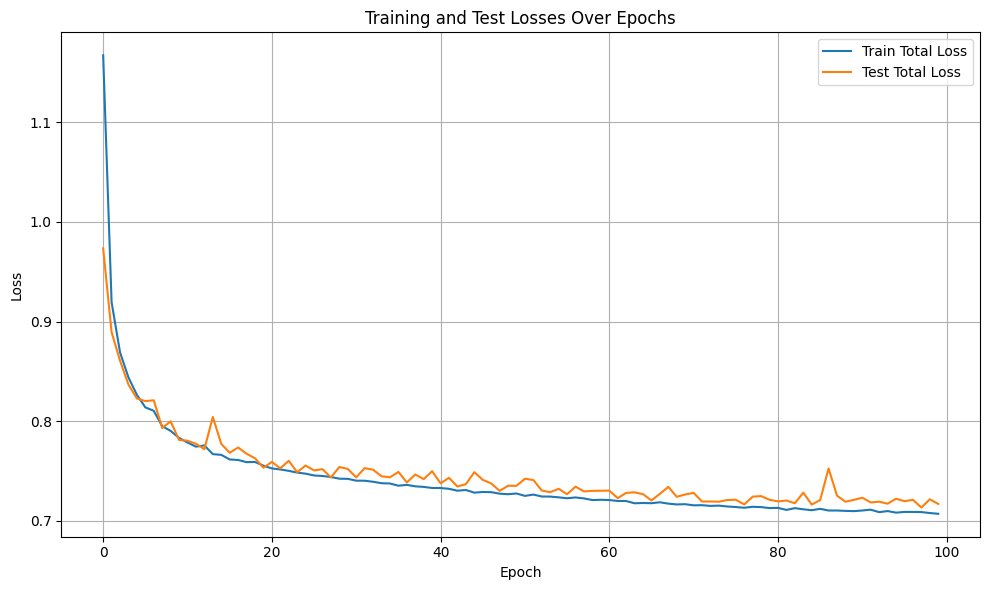

In [141]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Total Loss')
plt.plot(test_losses, label='Test Total Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [142]:
from rdkit import Chem, RDLogger
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

RDLogger.DisableLog('rdApp.*')  

results = []  

def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

def predict_g(smiles_string, chemberta_model, tokenizer, regressor_model, device):
    with torch.no_grad():
        encoded = tokenizer(smiles_string, return_tensors="pt", padding=True, truncation=True).to(device)
        output = chemberta_model(**encoded)
        feature = output.pooler_output.squeeze(0).unsqueeze(0).to(dtype=torch.float32)
    regressor_model.eval()
    with torch.no_grad():
        prediction = regressor_model(feature.to(device)).item()
    return prediction

In [143]:
for g in test_g.tolist():
    smiles = sample(model, g, temperature = 1.0)
    if is_valid_smiles(smiles):
        try:
            pred_g = predict_g(smiles, chemberta_model, tokenizer, trained_model, device=DEVICE)
            results.append({
                "True_G": g,
                "Predicted_G": pred_g,
                "Predicted_SMILES": smiles
            })
        except Exception as e:
            print(f"Error predicting G for SMILES: {smiles} | Error: {e}")
            continue

df_results = pd.DataFrame(results)

valid = len(df_results)
total = len(test_g)
valid_percent = (valid / total) * 100
print(f"\nValid SMILES: {valid}/{total} ({valid_percent:.2f}%)")

if valid > 0:
    mse = mean_squared_error(df_results['True_G'], df_results['Predicted_G'])
    mae = mean_absolute_error(df_results['True_G'], df_results['Predicted_G'])
    r2 = r2_score(df_results['True_G'], df_results['Predicted_G'])

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²:  {r2:.4f}")
else:
    print("No valid SMILES to evaluate.")


Valid SMILES: 48582/53554 (90.72%)
MSE: 99.6369
MAE: 6.5284
R²:  0.9369


In [144]:
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem

def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)

training_fps = [get_fingerprint(smiles) for smiles in train_smi]

def calculate_tanimoto_similarity(pred_smiles, training_fps):
    pred_fps = get_fingerprint(pred_smiles)
    similarities = DataStructs.BulkTanimotoSimilarity(pred_fps, training_fps)
    return max(similarities)  # Get the highest similarity to any training SMILES

df_results['Tanimoto_Similarity'] = df_results['Predicted_SMILES'].apply(lambda x: calculate_tanimoto_similarity(x, training_fps))

In [145]:
new_mols = df_results[df_results['Tanimoto_Similarity'] < 1]
num_new = len(new_mols)
total = len(df_results)
percent_new = 100 * num_new / total

print(f"New SMILES: {num_new}/{total} ({percent_new:.2f}%)")

mse = mean_squared_error(new_mols['True_G'], new_mols['Predicted_G'])
mae = mean_absolute_error(new_mols['True_G'], new_mols['Predicted_G'])
r2 = r2_score(new_mols['True_G'], new_mols['Predicted_G'])

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")

New SMILES: 31509/48582 (64.86%)
MSE: 114.3206
MAE: 7.0158
R²:  0.9248


In [146]:
df_results.to_csv("results_60.csv", index=False)

## 45% Training Data

In [147]:
train_smi, test_smi, train_g, test_g = train_test_split(df['SMILES'], df['G'], test_size=0.55, random_state=42)
train_ds = SmilesDataset(train_smi.tolist(), train_g.tolist())
test_ds = SmilesDataset(test_smi.tolist(), test_g.tolist())
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

model = PropertyVAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=tok2idx['<pad>'])

In [148]:
EPOCHS = 100

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = epoch_recon = epoch_kl = 0
    for x, prop in train_dl:
        x, prop = x.to(DEVICE), prop.to(DEVICE)
        optimizer.zero_grad()
        logits, mu, logvar = model(x[:, :-1], prop)  # logits: [B, MAX_LEN, V]
        target = x[:, 1:]
        logits = logits[:, :target.size(1), :]  # ensure same length
        recon_loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()
    train_losses.append(epoch_loss / len(train_dl))

    model.eval()
    with torch.no_grad():
        val_loss = val_recon = val_kl = 0
        for x, prop in test_dl:
            x, prop = x.to(DEVICE), prop.to(DEVICE)
            logits, mu, logvar = model(x[:, :-1], prop)
            target = x[:, 1:]
            logits = logits[:, :target.size(1), :]
            recon_loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
            loss = recon_loss + kl_loss
            val_loss += loss.item()
        test_losses.append(val_loss / len(test_dl))

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch [1/100], Train Loss: 1.2140, Test Loss: 1.0007
Epoch [2/100], Train Loss: 0.9468, Test Loss: 0.9031
Epoch [3/100], Train Loss: 0.8879, Test Loss: 0.8744
Epoch [4/100], Train Loss: 0.8549, Test Loss: 0.8439
Epoch [5/100], Train Loss: 0.8324, Test Loss: 0.8202
Epoch [6/100], Train Loss: 0.8175, Test Loss: 0.8052
Epoch [7/100], Train Loss: 0.8050, Test Loss: 0.7989
Epoch [8/100], Train Loss: 0.7995, Test Loss: 0.7864
Epoch [9/100], Train Loss: 0.7910, Test Loss: 0.7897
Epoch [10/100], Train Loss: 0.7833, Test Loss: 0.7811
Epoch [11/100], Train Loss: 0.7798, Test Loss: 0.7868
Epoch [12/100], Train Loss: 0.7745, Test Loss: 0.7744
Epoch [13/100], Train Loss: 0.7720, Test Loss: 0.7781
Epoch [14/100], Train Loss: 0.7732, Test Loss: 0.7674
Epoch [15/100], Train Loss: 0.7658, Test Loss: 0.7678
Epoch [16/100], Train Loss: 0.7607, Test Loss: 0.7712
Epoch [17/100], Train Loss: 0.7602, Test Loss: 0.7679
Epoch [18/100], Train Loss: 0.7569, Test Loss: 0.7624
Epoch [19/100], Train Loss: 0.7571, T

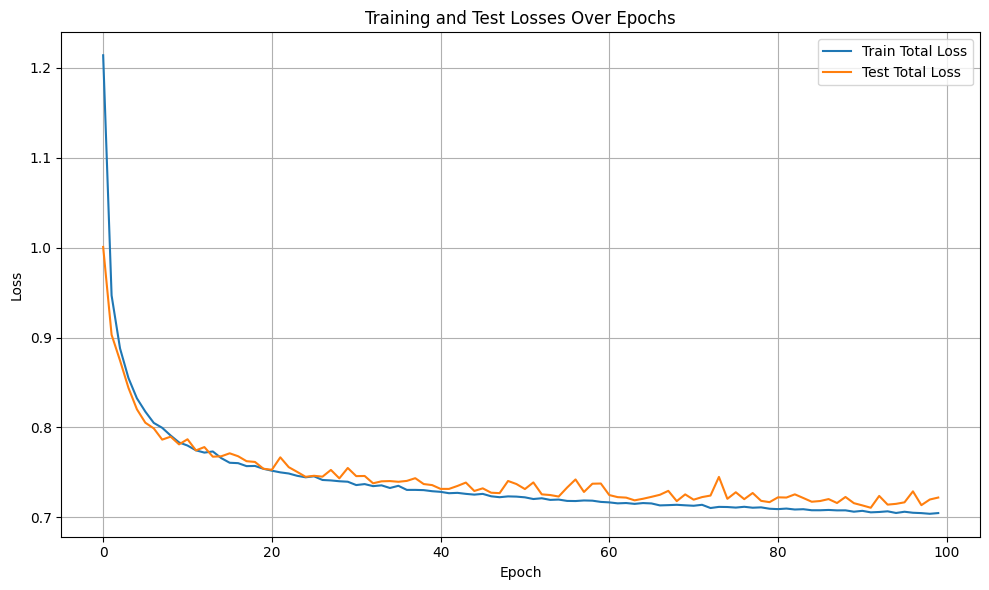

In [149]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Total Loss')
plt.plot(test_losses, label='Test Total Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [150]:
from rdkit import Chem, RDLogger
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

RDLogger.DisableLog('rdApp.*')  

results = []  

def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

def predict_g(smiles_string, chemberta_model, tokenizer, regressor_model, device):
    with torch.no_grad():
        encoded = tokenizer(smiles_string, return_tensors="pt", padding=True, truncation=True).to(device)
        output = chemberta_model(**encoded)
        feature = output.pooler_output.squeeze(0).unsqueeze(0).to(dtype=torch.float32)
    regressor_model.eval()
    with torch.no_grad():
        prediction = regressor_model(feature.to(device)).item()
    return prediction

In [151]:
for g in test_g.tolist():
    smiles = sample(model, g, temperature = 1.0)
    if is_valid_smiles(smiles):
        try:
            pred_g = predict_g(smiles, chemberta_model, tokenizer, trained_model, device=DEVICE)
            results.append({
                "True_G": g,
                "Predicted_G": pred_g,
                "Predicted_SMILES": smiles
            })
        except Exception as e:
            print(f"Error predicting G for SMILES: {smiles} | Error: {e}")
            continue

df_results = pd.DataFrame(results)

valid = len(df_results)
total = len(test_g)
valid_percent = (valid / total) * 100
print(f"\nValid SMILES: {valid}/{total} ({valid_percent:.2f}%)")

if valid > 0:
    mse = mean_squared_error(df_results['True_G'], df_results['Predicted_G'])
    mae = mean_absolute_error(df_results['True_G'], df_results['Predicted_G'])
    r2 = r2_score(df_results['True_G'], df_results['Predicted_G'])

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²:  {r2:.4f}")
else:
    print("No valid SMILES to evaluate.")


Valid SMILES: 65271/73637 (88.64%)
MSE: 94.5866
MAE: 6.4819
R²:  0.9405


In [152]:
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem

def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)

training_fps = [get_fingerprint(smiles) for smiles in train_smi]

def calculate_tanimoto_similarity(pred_smiles, training_fps):
    pred_fps = get_fingerprint(pred_smiles)
    similarities = DataStructs.BulkTanimotoSimilarity(pred_fps, training_fps)
    return max(similarities)  # Get the highest similarity to any training SMILES

df_results['Tanimoto_Similarity'] = df_results['Predicted_SMILES'].apply(lambda x: calculate_tanimoto_similarity(x, training_fps))

In [153]:
new_mols = df_results[df_results['Tanimoto_Similarity'] < 1]
num_new = len(new_mols)
total = len(df_results)
percent_new = 100 * num_new / total

print(f"New SMILES: {num_new}/{total} ({percent_new:.2f}%)")

mse = mean_squared_error(new_mols['True_G'], new_mols['Predicted_G'])
mae = mean_absolute_error(new_mols['True_G'], new_mols['Predicted_G'])
r2 = r2_score(new_mols['True_G'], new_mols['Predicted_G'])

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")

New SMILES: 48260/65271 (73.94%)
MSE: 101.3392
MAE: 6.7435
R²:  0.9334


In [154]:
df_results.to_csv("results_45.csv", index=False)

## 30% Training Data

In [155]:
train_smi, test_smi, train_g, test_g = train_test_split(df['SMILES'], df['G'], test_size=0.7, random_state=42)
train_ds = SmilesDataset(train_smi.tolist(), train_g.tolist())
test_ds = SmilesDataset(test_smi.tolist(), test_g.tolist())
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

model = PropertyVAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=tok2idx['<pad>'])

In [156]:
EPOCHS = 100

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = epoch_recon = epoch_kl = 0
    for x, prop in train_dl:
        x, prop = x.to(DEVICE), prop.to(DEVICE)
        optimizer.zero_grad()
        logits, mu, logvar = model(x[:, :-1], prop)  # logits: [B, MAX_LEN, V]
        target = x[:, 1:]
        logits = logits[:, :target.size(1), :]  # ensure same length
        recon_loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()
    train_losses.append(epoch_loss / len(train_dl))

    model.eval()
    with torch.no_grad():
        val_loss = val_recon = val_kl = 0
        for x, prop in test_dl:
            x, prop = x.to(DEVICE), prop.to(DEVICE)
            logits, mu, logvar = model(x[:, :-1], prop)
            target = x[:, 1:]
            logits = logits[:, :target.size(1), :]
            recon_loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
            loss = recon_loss + kl_loss
            val_loss += loss.item()
        test_losses.append(val_loss / len(test_dl))

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch [1/100], Train Loss: 1.3215, Test Loss: 1.0800
Epoch [2/100], Train Loss: 1.0009, Test Loss: 0.9530
Epoch [3/100], Train Loss: 0.9342, Test Loss: 0.9358
Epoch [4/100], Train Loss: 0.9009, Test Loss: 0.8922
Epoch [5/100], Train Loss: 0.8775, Test Loss: 0.8698
Epoch [6/100], Train Loss: 0.8628, Test Loss: 0.8551
Epoch [7/100], Train Loss: 0.8507, Test Loss: 0.8458
Epoch [8/100], Train Loss: 0.8435, Test Loss: 0.8473
Epoch [9/100], Train Loss: 0.8318, Test Loss: 0.8300
Epoch [10/100], Train Loss: 0.8250, Test Loss: 0.8216
Epoch [11/100], Train Loss: 0.8205, Test Loss: 0.8190
Epoch [12/100], Train Loss: 0.8146, Test Loss: 0.8384
Epoch [13/100], Train Loss: 0.8067, Test Loss: 0.8026
Epoch [14/100], Train Loss: 0.8019, Test Loss: 0.8188
Epoch [15/100], Train Loss: 0.8122, Test Loss: 0.8220
Epoch [16/100], Train Loss: 0.7946, Test Loss: 0.7927
Epoch [17/100], Train Loss: 0.7905, Test Loss: 0.7959
Epoch [18/100], Train Loss: 0.7859, Test Loss: 0.7881
Epoch [19/100], Train Loss: 0.7862, T

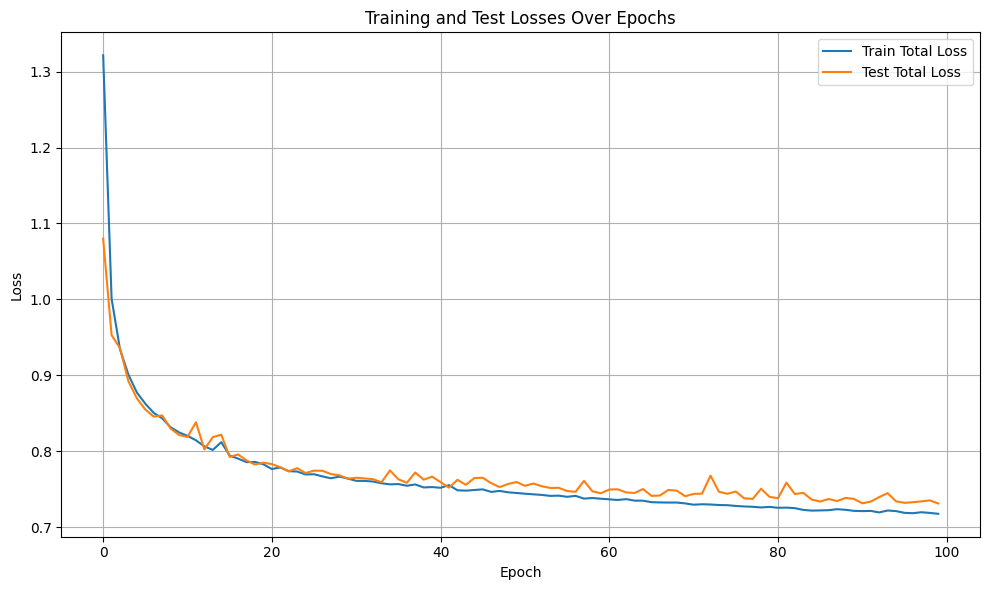

In [157]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Total Loss')
plt.plot(test_losses, label='Test Total Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [158]:
from rdkit import Chem, RDLogger
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

RDLogger.DisableLog('rdApp.*')  

results = []  

def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

def predict_g(smiles_string, chemberta_model, tokenizer, regressor_model, device):
    with torch.no_grad():
        encoded = tokenizer(smiles_string, return_tensors="pt", padding=True, truncation=True).to(device)
        output = chemberta_model(**encoded)
        feature = output.pooler_output.squeeze(0).unsqueeze(0).to(dtype=torch.float32)
    regressor_model.eval()
    with torch.no_grad():
        prediction = regressor_model(feature.to(device)).item()
    return prediction

In [159]:
for g in test_g.tolist():
    smiles = sample(model, g, temperature = 1.0)
    if is_valid_smiles(smiles):
        try:
            pred_g = predict_g(smiles, chemberta_model, tokenizer, trained_model, device=DEVICE)
            results.append({
                "True_G": g,
                "Predicted_G": pred_g,
                "Predicted_SMILES": smiles
            })
        except Exception as e:
            print(f"Error predicting G for SMILES: {smiles} | Error: {e}")
            continue

df_results = pd.DataFrame(results)

valid = len(df_results)
total = len(test_g)
valid_percent = (valid / total) * 100
print(f"\nValid SMILES: {valid}/{total} ({valid_percent:.2f}%)")

if valid > 0:
    mse = mean_squared_error(df_results['True_G'], df_results['Predicted_G'])
    mae = mean_absolute_error(df_results['True_G'], df_results['Predicted_G'])
    r2 = r2_score(df_results['True_G'], df_results['Predicted_G'])

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²:  {r2:.4f}")
else:
    print("No valid SMILES to evaluate.")


Valid SMILES: 84687/93720 (90.36%)
MSE: 103.4964
MAE: 6.7585
R²:  0.9352


In [160]:
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem

def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)

training_fps = [get_fingerprint(smiles) for smiles in train_smi]

def calculate_tanimoto_similarity(pred_smiles, training_fps):
    pred_fps = get_fingerprint(pred_smiles)
    similarities = DataStructs.BulkTanimotoSimilarity(pred_fps, training_fps)
    return max(similarities)  # Get the highest similarity to any training SMILES

df_results['Tanimoto_Similarity'] = df_results['Predicted_SMILES'].apply(lambda x: calculate_tanimoto_similarity(x, training_fps))

In [161]:
new_mols = df_results[df_results['Tanimoto_Similarity'] < 1]
num_new = len(new_mols)
total = len(df_results)
percent_new = 100 * num_new / total

print(f"New SMILES: {num_new}/{total} ({percent_new:.2f}%)")

mse = mean_squared_error(new_mols['True_G'], new_mols['Predicted_G'])
mae = mean_absolute_error(new_mols['True_G'], new_mols['Predicted_G'])
r2 = r2_score(new_mols['True_G'], new_mols['Predicted_G'])

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")

New SMILES: 69811/84687 (82.43%)
MSE: 109.2082
MAE: 6.9642
R²:  0.9295


In [162]:
df_results.to_csv("results_30.csv", index=False)

## 15% Training Data

In [163]:
train_smi, test_smi, train_g, test_g = train_test_split(df['SMILES'], df['G'], test_size=0.85, random_state=42)
train_ds = SmilesDataset(train_smi.tolist(), train_g.tolist())
test_ds = SmilesDataset(test_smi.tolist(), test_g.tolist())
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

model = PropertyVAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=tok2idx['<pad>'])

In [164]:
EPOCHS = 100

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = epoch_recon = epoch_kl = 0
    for x, prop in train_dl:
        x, prop = x.to(DEVICE), prop.to(DEVICE)
        optimizer.zero_grad()
        logits, mu, logvar = model(x[:, :-1], prop)  # logits: [B, MAX_LEN, V]
        target = x[:, 1:]
        logits = logits[:, :target.size(1), :]  # ensure same length
        recon_loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()
    train_losses.append(epoch_loss / len(train_dl))

    model.eval()
    with torch.no_grad():
        val_loss = val_recon = val_kl = 0
        for x, prop in test_dl:
            x, prop = x.to(DEVICE), prop.to(DEVICE)
            logits, mu, logvar = model(x[:, :-1], prop)
            target = x[:, 1:]
            logits = logits[:, :target.size(1), :]
            recon_loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
            loss = recon_loss + kl_loss
            val_loss += loss.item()
        test_losses.append(val_loss / len(test_dl))

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch [1/100], Train Loss: 1.5299, Test Loss: 1.2010
Epoch [2/100], Train Loss: 1.1167, Test Loss: 1.0495
Epoch [3/100], Train Loss: 1.0239, Test Loss: 0.9928
Epoch [4/100], Train Loss: 0.9739, Test Loss: 0.9544
Epoch [5/100], Train Loss: 0.9446, Test Loss: 0.9329
Epoch [6/100], Train Loss: 0.9165, Test Loss: 0.9093
Epoch [7/100], Train Loss: 0.9029, Test Loss: 0.9019
Epoch [8/100], Train Loss: 0.8881, Test Loss: 0.8770
Epoch [9/100], Train Loss: 0.8767, Test Loss: 0.8721
Epoch [10/100], Train Loss: 0.8705, Test Loss: 0.8637
Epoch [11/100], Train Loss: 0.8566, Test Loss: 0.8581
Epoch [12/100], Train Loss: 0.8532, Test Loss: 0.8659
Epoch [13/100], Train Loss: 0.8460, Test Loss: 0.8415
Epoch [14/100], Train Loss: 0.8383, Test Loss: 0.8387
Epoch [15/100], Train Loss: 0.8393, Test Loss: 0.8411
Epoch [16/100], Train Loss: 0.8315, Test Loss: 0.8382
Epoch [17/100], Train Loss: 0.8274, Test Loss: 0.8337
Epoch [18/100], Train Loss: 0.8212, Test Loss: 0.8349
Epoch [19/100], Train Loss: 0.8204, T

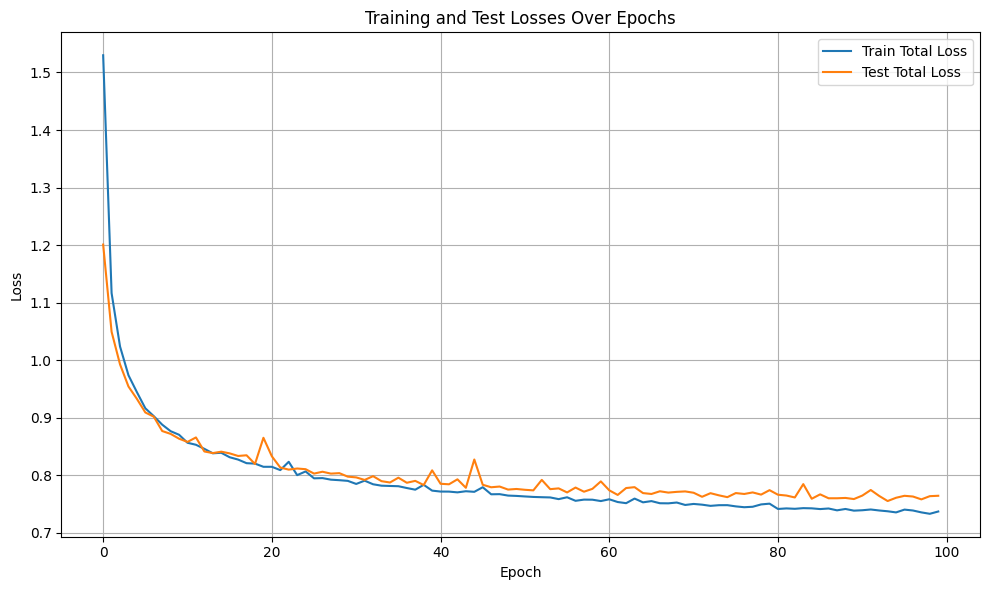

In [165]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Total Loss')
plt.plot(test_losses, label='Test Total Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [166]:
from rdkit import Chem, RDLogger
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

RDLogger.DisableLog('rdApp.*')  

results = []  

def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

def predict_g(smiles_string, chemberta_model, tokenizer, regressor_model, device):
    with torch.no_grad():
        encoded = tokenizer(smiles_string, return_tensors="pt", padding=True, truncation=True).to(device)
        output = chemberta_model(**encoded)
        feature = output.pooler_output.squeeze(0).unsqueeze(0).to(dtype=torch.float32)
    regressor_model.eval()
    with torch.no_grad():
        prediction = regressor_model(feature.to(device)).item()
    return prediction

In [167]:
for g in test_g.tolist():
    smiles = sample(model, g, temperature = 1.0)
    if is_valid_smiles(smiles):
        try:
            pred_g = predict_g(smiles, chemberta_model, tokenizer, trained_model, device=DEVICE)
            results.append({
                "True_G": g,
                "Predicted_G": pred_g,
                "Predicted_SMILES": smiles
            })
        except Exception as e:
            print(f"Error predicting G for SMILES: {smiles} | Error: {e}")
            continue

df_results = pd.DataFrame(results)

valid = len(df_results)
total = len(test_g)
valid_percent = (valid / total) * 100
print(f"\nValid SMILES: {valid}/{total} ({valid_percent:.2f}%)")

if valid > 0:
    mse = mean_squared_error(df_results['True_G'], df_results['Predicted_G'])
    mae = mean_absolute_error(df_results['True_G'], df_results['Predicted_G'])
    r2 = r2_score(df_results['True_G'], df_results['Predicted_G'])

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²:  {r2:.4f}")
else:
    print("No valid SMILES to evaluate.")


Valid SMILES: 98804/113803 (86.82%)
MSE: 144.9955
MAE: 8.3849
R²:  0.9088


In [168]:
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem

def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)

training_fps = [get_fingerprint(smiles) for smiles in train_smi]

def calculate_tanimoto_similarity(pred_smiles, training_fps):
    pred_fps = get_fingerprint(pred_smiles)
    similarities = DataStructs.BulkTanimotoSimilarity(pred_fps, training_fps)
    return max(similarities)  # Get the highest similarity to any training SMILES

df_results['Tanimoto_Similarity'] = df_results['Predicted_SMILES'].apply(lambda x: calculate_tanimoto_similarity(x, training_fps))

In [169]:
new_mols = df_results[df_results['Tanimoto_Similarity'] < 1]
num_new = len(new_mols)
total = len(df_results)
percent_new = 100 * num_new / total

print(f"New SMILES: {num_new}/{total} ({percent_new:.2f}%)")

mse = mean_squared_error(new_mols['True_G'], new_mols['Predicted_G'])
mae = mean_absolute_error(new_mols['True_G'], new_mols['Predicted_G'])
r2 = r2_score(new_mols['True_G'], new_mols['Predicted_G'])

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")

New SMILES: 90006/98804 (91.10%)
MSE: 147.1791
MAE: 8.4455
R²:  0.9053


In [170]:
df_results.to_csv("results_15.csv", index=False)

In [171]:
import matplotlib.pyplot as plt

# --------- Data for Temperature Sweep (90% Training Data) ---------
temps = [0.6, 0.8, 1.0, 1.2, 1.4]

valid_counts_temp = [12808, 12664, 12241, 11841, 11200]
new_counts_temp = [4606, 4973, 5489, 6006, 6254]

mse_all_temp = [57.0044, 93.1556, 103.2548, 128.0723, 168.3655]
mae_all_temp = [4.9747, 5.4096, 6.2752, 7.0677, 8.0353]
r2_all_temp  = [0.9646, 0.9422, 0.9352, 0.9203, 0.8945]

mse_new_temp = [67.1377, 150.2407, 126.0499, 151.1547, 196.1522]
mae_new_temp = [5.5385, 6.1900, 7.1734, 7.9877, 9.0678]
r2_new_temp  = [0.9558, 0.8978, 0.9148, 0.9005, 0.8702]

# --------- Data for Training Size Sweep (Temp = 1.0) ---------
training_sizes = [90, 75, 60, 45, 30, 15]

valid_counts_train = [12241, 30631, 48582, 65271, 84687, 98804]
new_counts_train = [5489, 16619, 31509, 48260, 69811, 90006]

mse_all_train = [103.2548, 108.3128, 99.6369, 94.5866, 103.4964, 144.9955]
mae_all_train = [6.2752, 6.5615, 6.5284, 6.4819, 6.7585, 8.3849]
r2_all_train  = [0.9352, 0.9317, 0.9369, 0.9405, 0.9352, 0.9088]

mse_new_train = [126.0499, 132.1215, 114.3206, 101.3392, 109.2082, 147.1791]
mae_new_train = [7.1734, 7.3340, 7.0158, 6.7435, 6.9642, 8.4455]
r2_new_train  = [0.9148, 0.9114, 0.9248, 0.9334, 0.9295, 0.9053]

In [172]:
def plot_metric_vs_x(x, y1, y2, x_label, y_label, title, labels):
    plt.figure(figsize=(6, 4))
    plt.plot(x, y1, 'o-', label=labels[0])
    plt.plot(x, y2, 's--', label=labels[1])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

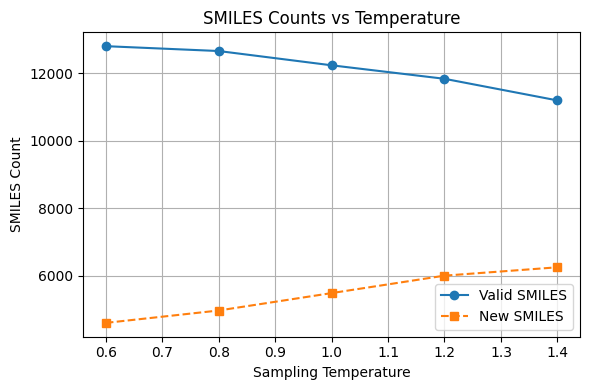

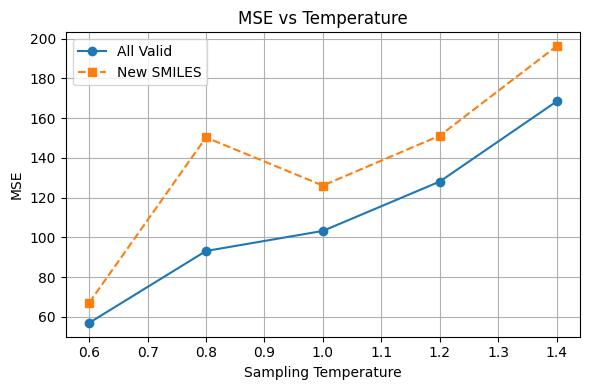

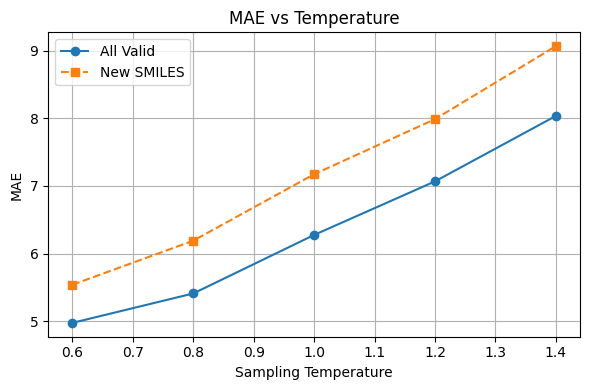

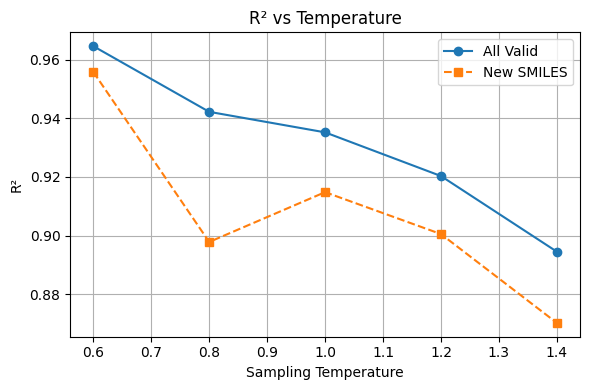

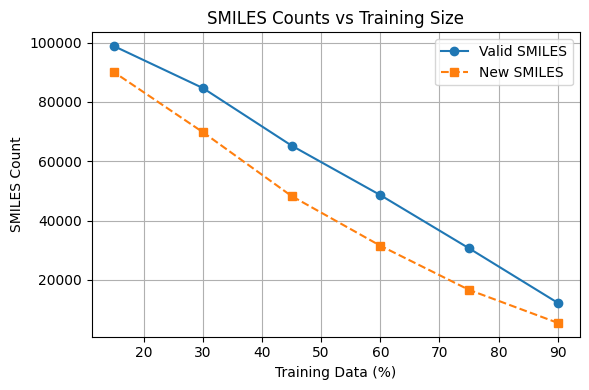

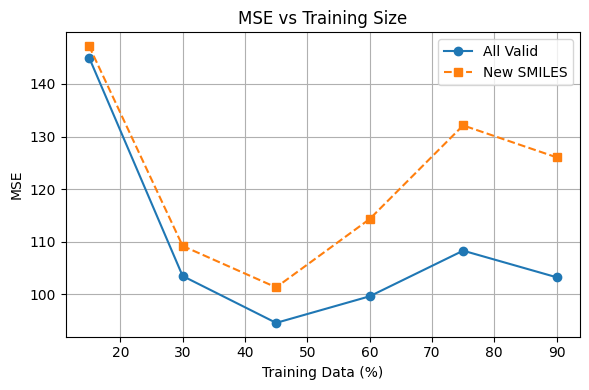

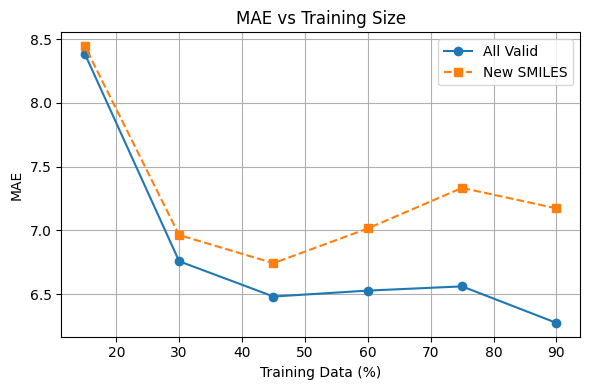

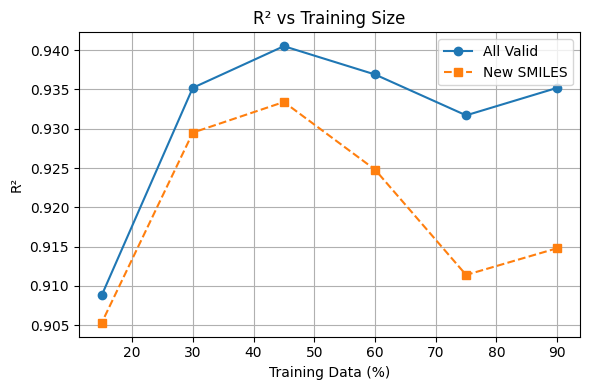

In [173]:
plot_metric_vs_x(temps, valid_counts_temp, new_counts_temp, 
                 "Sampling Temperature", "SMILES Count", "SMILES Counts vs Temperature",
                 ["Valid SMILES", "New SMILES"])

plot_metric_vs_x(temps, mse_all_temp, mse_new_temp, 
                 "Sampling Temperature", "MSE", "MSE vs Temperature",
                 ["All Valid", "New SMILES"])

plot_metric_vs_x(temps, mae_all_temp, mae_new_temp, 
                 "Sampling Temperature", "MAE", "MAE vs Temperature",
                 ["All Valid", "New SMILES"])

plot_metric_vs_x(temps, r2_all_temp, r2_new_temp, 
                 "Sampling Temperature", "R²", "R² vs Temperature",
                 ["All Valid", "New SMILES"])

plot_metric_vs_x(training_sizes, valid_counts_train, new_counts_train, 
                 "Training Data (%)", "SMILES Count", "SMILES Counts vs Training Size",
                 ["Valid SMILES", "New SMILES"])

plot_metric_vs_x(training_sizes, mse_all_train, mse_new_train, 
                 "Training Data (%)", "MSE", "MSE vs Training Size",
                 ["All Valid", "New SMILES"])

plot_metric_vs_x(training_sizes, mae_all_train, mae_new_train, 
                 "Training Data (%)", "MAE", "MAE vs Training Size",
                 ["All Valid", "New SMILES"])

plot_metric_vs_x(training_sizes, r2_all_train, r2_new_train, 
                 "Training Data (%)", "R²", "R² vs Training Size",
                 ["All Valid", "New SMILES"])

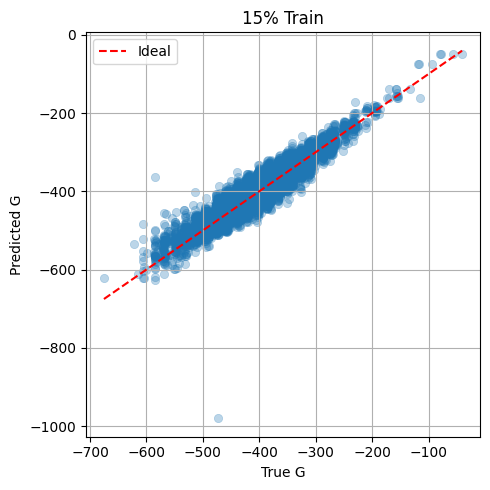

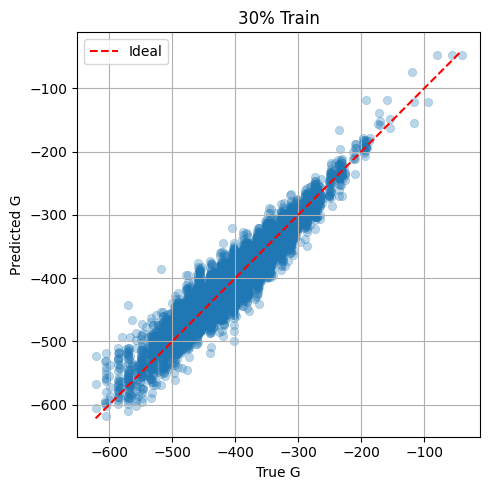

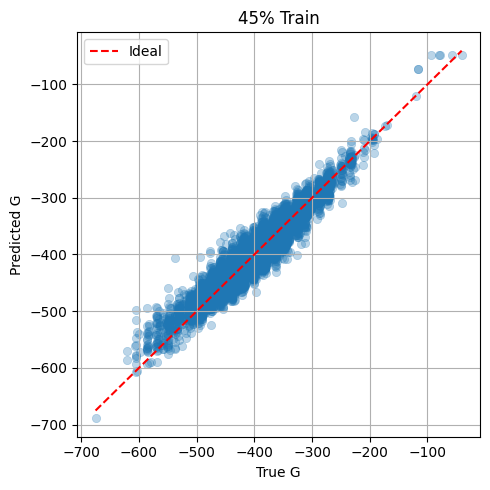

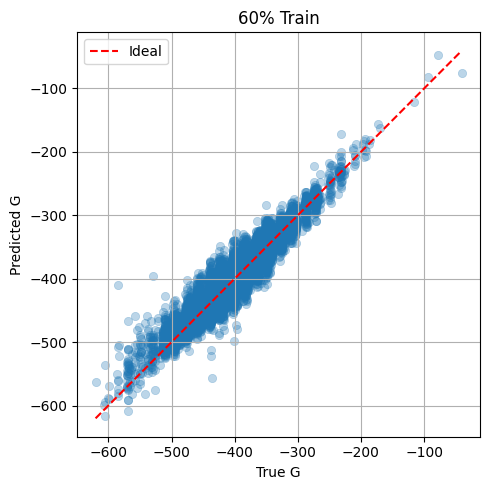

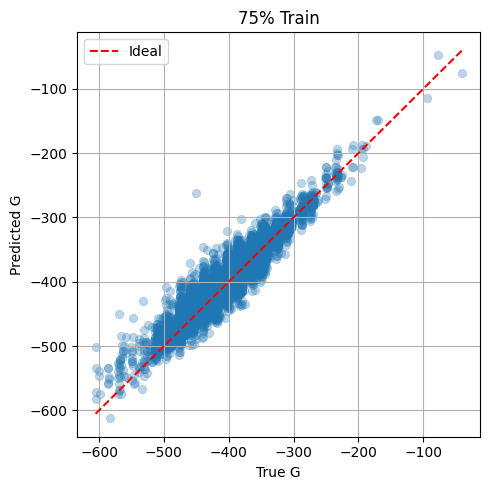

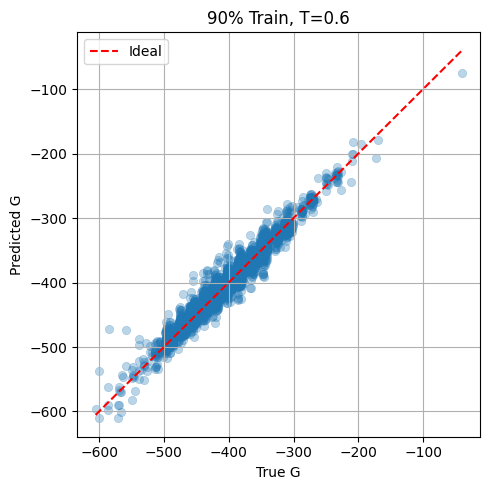

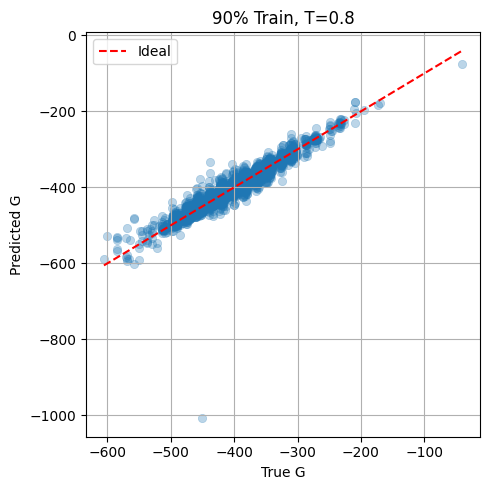

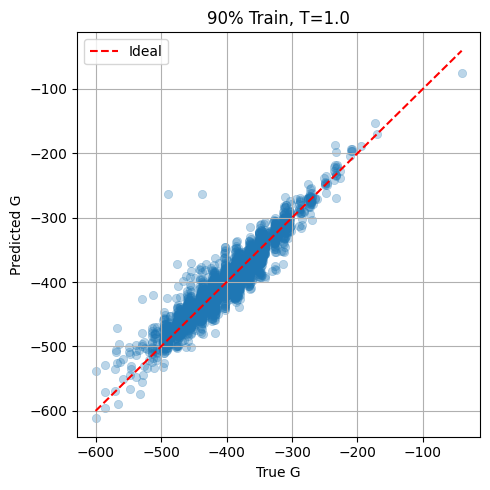

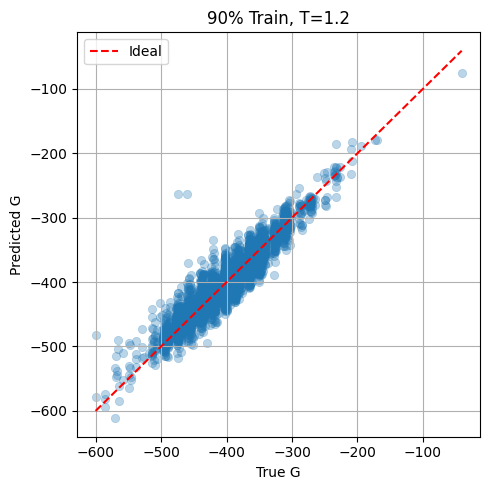

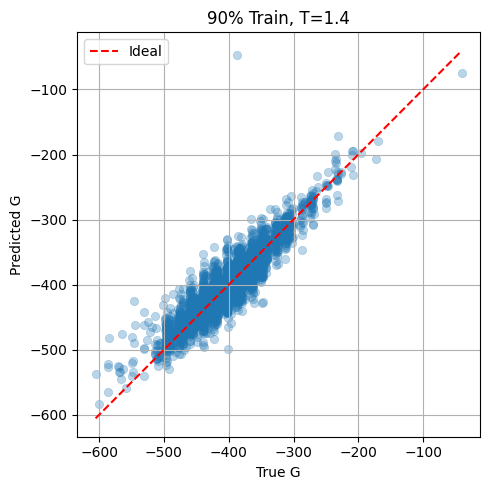

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

files = {
    "15% Train": "/kaggle/working/results_15.csv",
    "30% Train": "/kaggle/working/results_30.csv",
    "45% Train": "/kaggle/working/results_45.csv",
    "60% Train": "/kaggle/working/results_60.csv",
    "75% Train": "/kaggle/working/results_75.csv",
    "90% Train, T=0.6": "/kaggle/working/results_75_t6.csv",
    "90% Train, T=0.8": "/kaggle/working/results_75_t8.csv",
    "90% Train, T=1.0": "/kaggle/working/results_75_t10.csv",
    "90% Train, T=1.2": "/kaggle/working/results_75_t12.csv",
    "90% Train, T=1.4": "/kaggle/working/results_75_t14.csv"
}

# Scatter plot function
def plot_scatter(df, label):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(x='True_G', y='Predicted_G', data=df, alpha=0.3, edgecolor=None)
    plt.plot([df['True_G'].min(), df['True_G'].max()],
             [df['True_G'].min(), df['True_G'].max()], 'r--', label='Ideal')
    plt.xlabel('True G')
    plt.ylabel('Predicted G')
    plt.title(label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

for label, file in files.items():
    df = pd.read_csv(file)
    plot_scatter(df, label)